In [5]:
from DecisionTree import DecisionTree
from Model import *
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, precision_score, recall_score, auc as AUC
from sklearn.preprocessing import LabelEncoder
from EnsembleLearning import *
from sklearn.ensemble import RandomForestClassifier

In [6]:
def get_stats(labels, preds, do_plot=True):
    accuracy = np.sum(preds == labels) / len(labels)
    precision = np.mean([np.sum(labels[preds == x] == x) / np.sum(preds == x) for x in np.unique(preds)])
    recall = np.mean([np.sum(preds[labels == x] == x) / np.sum(labels == x) for x in np.unique(labels)])
    conf = np.array([[np.sum(labels[preds == y] == x) for x in np.unique(labels)] for y in np.unique(labels)])
    if do_plot:
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        fig, ax = plt.subplots(figsize=(4, 4))
        cax = ax.matshow(conf, cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(ticks=np.arange(len(np.unique(labels))), labels=np.unique(labels))
        plt.yticks(ticks=np.arange(len(np.unique(labels))), labels=np.unique(labels))
    
        for i in range(len(np.unique(labels))):
            for j in range(len(np.unique(labels))):
                ax.text(j, i, str(conf[i, j]), va='center', ha='center', color='black')
        
        plt.show()
    
    return accuracy, precision, recall, conf

def get_aupr(labels, pred_scores, thresholds):
    pr = np.array([(precision_score(labels, (~(pred_scores <= t)).astype(int), zero_division=1), recall_score(labels, (~(pred_scores <= t)).astype(int), zero_division=1)) for t in thresholds])
    return AUC(np.sort(pr[:, 0]), np.sort(pr[:, 1]))


In [7]:
df = pd.read_csv('dataset/abalone.data', header = None)
le = LabelEncoder()

In [8]:
df[8].unique()

array([15,  7,  9, 10,  8, 20, 16, 19, 14, 11, 12, 18, 13,  5,  4,  6, 21,
       17, 22,  1,  3, 26, 23, 29,  2, 27, 25, 24], dtype=int64)

In [9]:
targets = df.values[:, -1].astype(int)
targets[(targets != 5)&(targets != 6)] = 0
targets[(targets == 5)|(targets == 6)] = 1
data = df.values[:, :-1]
data[:,  0] = le.fit_transform(data[:, 0])
data = data.astype(float)

In [10]:
smote = SMOTE()
smote.fit(data, targets)
data, targets = smote.resample()
train_data, val_data, train_labels, val_labels = train_test_split(data, targets, test_size = 0.2, random_state = 42)

# Bagging - CART

Accuracy: 0.9534
Precision: 0.9532
Recall: 0.9540


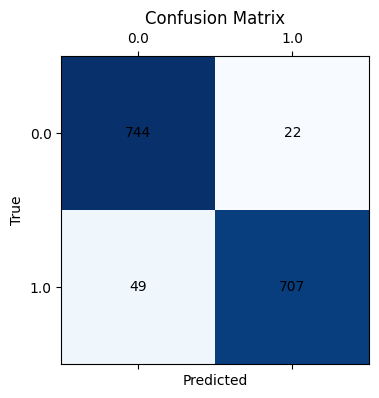

In [7]:
bag = Bagging(DecisionTree, method = 'cart')
bag.fit(train_data, train_labels)
preds = bag.predict(val_data)
stat = get_stats(val_labels, preds)

0.13738250566061713


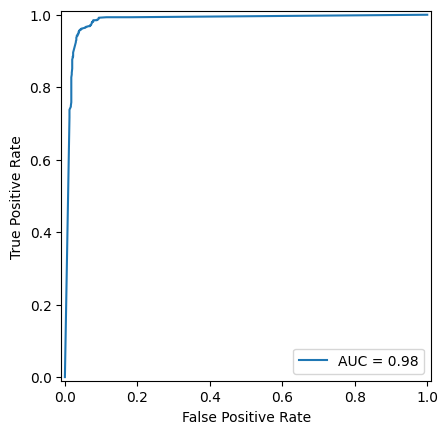

In [7]:
preds = bag.predict_prob(val_data)
auc = roc_auc_score(val_labels, preds)
fpr, tpr, thresholds = roc_curve(val_labels, preds)
print(get_aupr(val_labels, preds, thresholds))
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auc)
disp.plot()

### cross validation

In [12]:
bag = Bagging(base_model = DecisionTree, method = 'cart')
cross_validate(bag, train_data, train_labels, cv = 5, scoring = ['accuracy', 'precision_macro', 'recall_macro'])

{'fit_time': array([107.55995584,  92.57110763,  95.7877667 , 107.84571528,
         95.42621183]),
 'score_time': array([0.09782887, 0.09474659, 0.09275198, 0.14860153, 0.10771203]),
 'test_accuracy': array([0.95069844, 0.95398521, 0.95234182, 0.94823336, 0.94325658]),
 'test_precision_macro': array([0.95128431, 0.95437422, 0.95267909, 0.94851026, 0.94430144]),
 'test_recall_macro': array([0.95042846, 0.95410423, 0.95180889, 0.9487527 , 0.94282853])}

# Bagging - C4.5

Accuracy: 0.9593
Precision: 0.9590
Recall: 0.9597


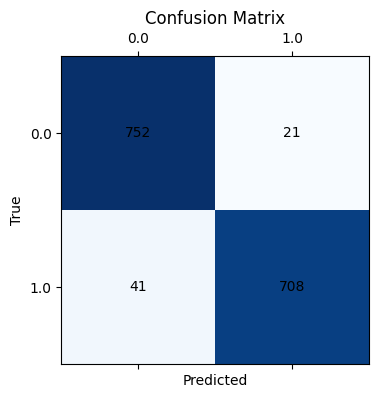

In [8]:
bag = Bagging(DecisionTree, method = 'c4.5')
bag.fit(train_data, train_labels)
preds = bag.predict(val_data)
stat = get_stats(val_labels, preds)

0.12440021964676642


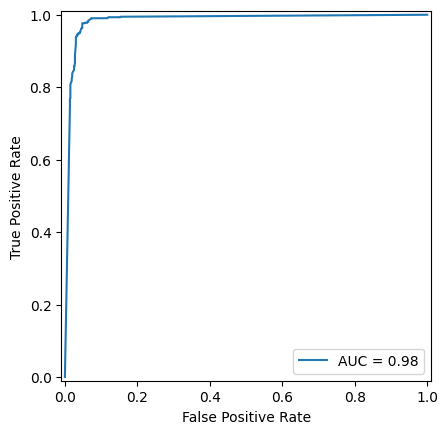

In [9]:
preds = bag.predict_prob(val_data)
auc = roc_auc_score(val_labels, preds)
fpr, tpr, thresholds = roc_curve(val_labels, preds)
print(get_aupr(val_labels, preds, thresholds))
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auc)
disp.plot()

# Boosting - CART

Accuracy: 0.8187
Precision: 0.8406
Recall: 0.8132


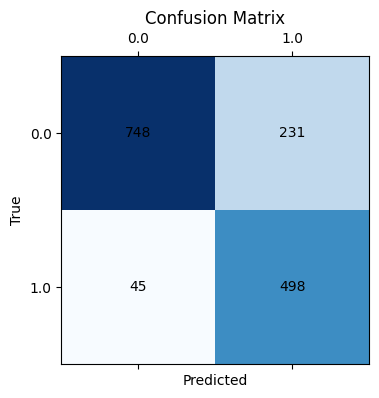

In [13]:
boost = Boosting(DecisionTree, method = 'cart')
boost.fit(train_data, train_labels)
preds = boost.predict(val_data)
stat = get_stats(val_labels, preds)

0.08202112305551795


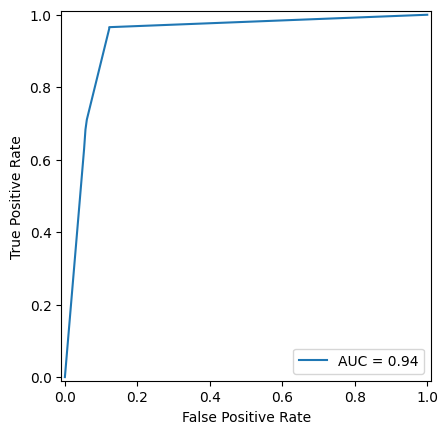

In [14]:
preds = boost.predict_prob(val_data)
auc = roc_auc_score(val_labels, preds)
fpr, tpr, thresholds = roc_curve(val_labels, preds)
print(get_aupr(val_labels, preds, thresholds))
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auc)
disp.plot()

### cross validation

In [15]:
boost = Boosting(base_model = DecisionTree, method = 'cart')
cross_validate(boost, train_data, train_labels, cv = 5, scoring = ['accuracy', 'precision_macro', 'recall_macro'])

{'fit_time': array([28.86337137, 25.53080964, 26.34652448, 25.5741055 , 26.26956868]),
 'score_time': array([0.00598431, 0.00598383, 0.01396322, 0.00598407, 0.00598407]),
 'test_accuracy': array([0.8085456 , 0.79046836, 0.76910435, 0.74691865, 0.79276316]),
 'test_precision_macro': array([0.8347205 , 0.82332929, 0.80471668, 0.79239579, 0.82409033]),
 'test_recall_macro': array([0.81094224, 0.78928406, 0.77740008, 0.74142568, 0.79579996])}

# Boosting - C4.5

Accuracy: 0.8187
Precision: 0.8406
Recall: 0.8132


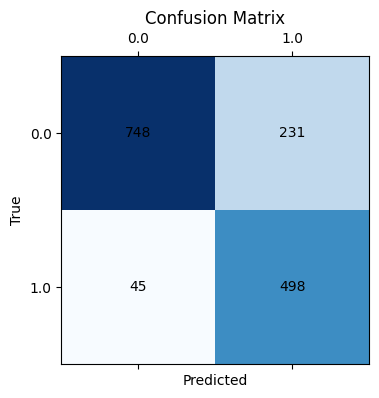

In [17]:
boost = Boosting(DecisionTree, method = 'c4.5')
boost.fit(train_data, train_labels)
preds = boost.predict(val_data)
stat = get_stats(val_labels, preds)

0.02855813404015506


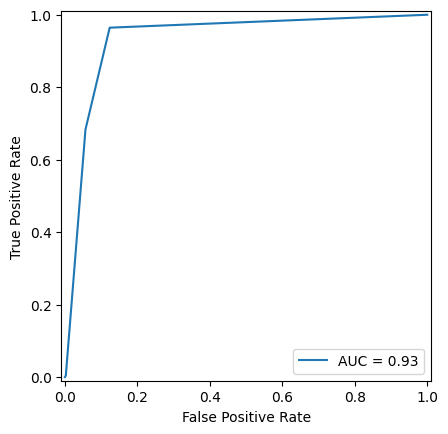

In [18]:
preds = boost.predict_prob(val_data)
auc = roc_auc_score(val_labels, preds)
fpr, tpr, thresholds = roc_curve(val_labels, preds)
print(get_aupr(val_labels, preds, thresholds))
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auc)
disp.plot()

# Bonus

In [11]:
np.unique(val_labels, return_counts = True)

(array([0., 1.]), array([793, 729], dtype=int64))

In [12]:
np.unique(targets, return_counts = True)

(array([0., 1.]), array([3803, 3803], dtype=int64))

In [13]:
np.unique(df.values[:, -1].astype(int), return_counts = True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29]),
 array([  1,   1,  15,  57, 115, 259, 391, 568, 689, 634, 487, 267, 203,
        126, 103,  67,  58,  42,  32,  26,  14,   6,   9,   2,   1,   1,
          2,   1], dtype=int64))

### noise 

In [17]:
train_data, val_data, train_labels, val_labels = train_test_split(data, targets, test_size = 0.2, random_state = 42)

In [14]:
smote = SMOTE()
smote.fit(train_data, train_labels)
r1 = smote.r1_risk(train_data, 1 - train_labels)
ind = np.where(train_labels == 0)[0]
noise_ind = np.random.choice(ind[np.where(r1[ind] < 0.3)], int(np.ceil(np.sum(train_labels == 1) * 0.1)), replace = False)
train_labels[noise_ind] = 1
train_data, train_labels = smote.resample()

In [18]:
smote = SMOTE()
smote.fit(train_data, train_labels)
r1 = smote.r1_risk(train_data, 1 - train_labels)
ind = np.where(train_labels == 0)[0]
noise_ind = np.random.choice(ind[np.where(r1[ind] < 0.3)], int(np.ceil(np.sum(train_labels == 1) * 0.1)), replace = False)
train_labels[noise_ind] = 1
train_data, train_labels = smote.resample()

## Bagging - CART

Accuracy: 0.9356
Precision: 0.9359
Recall: 0.9366


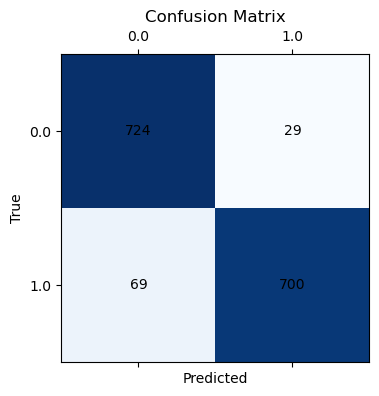

In [19]:
bag = Bagging(DecisionTree, method = 'cart')
bag.fit(train_data, train_labels)
preds = bag.predict(val_data)
stat = get_stats(val_labels, preds)

0.3838781406395836


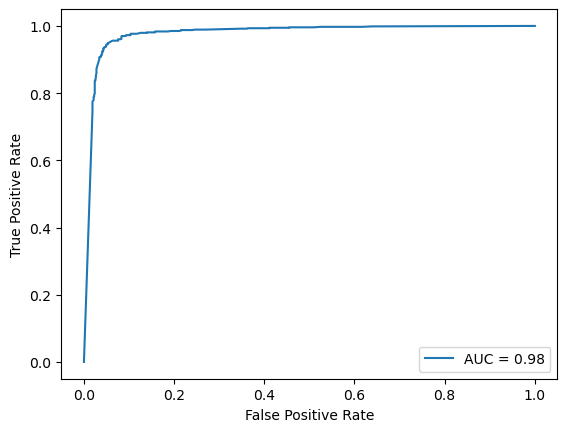

In [20]:
preds = bag.predict_prob(val_data)
auc = roc_auc_score(val_labels, preds)
fpr, tpr, thresholds = roc_curve(val_labels, preds)
print(get_aupr(val_labels, preds, thresholds))
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auc)
disp.plot()

## BOOSTING - CART

Accuracy: 0.8522
Precision: 0.8576
Recall: 0.8495


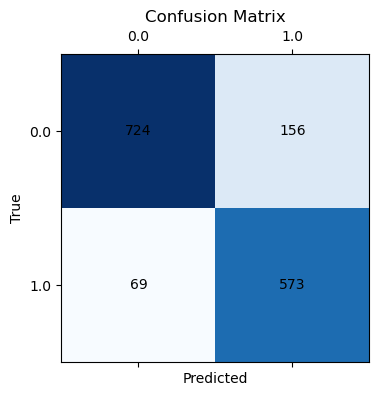

In [21]:
boost = Boosting(DecisionTree, method = 'cart')
boost.fit(train_data, train_labels)
preds = boost.predict(val_data)
stat = get_stats(val_labels, preds)

0.07764266573332632


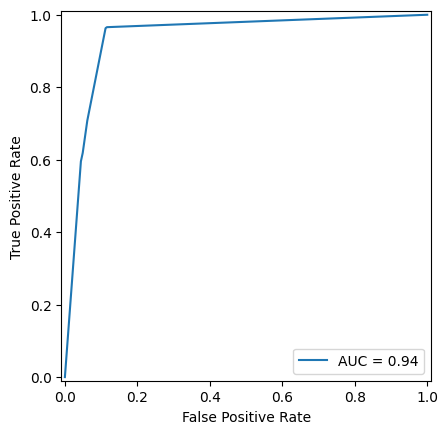

In [21]:
preds = boost.predict_prob(val_data)
auc = roc_auc_score(val_labels, preds)
fpr, tpr, thresholds = roc_curve(val_labels, preds)
print(get_aupr(val_labels, preds, thresholds))
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auc)
disp.plot()

# Random Forest

In [8]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(train_data, train_labels)
y_pred = clf.predict(val_data)

Accuracy: 0.9658
Precision: 0.9666
Recall: 0.9658


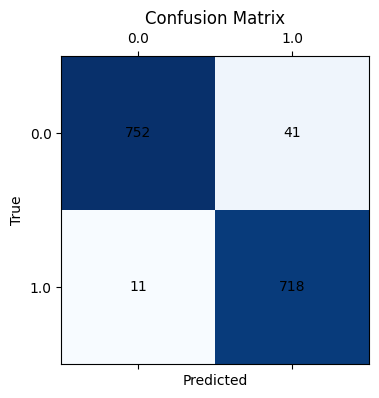

In [9]:
stats = get_stats(y_pred,val_labels)

0.0


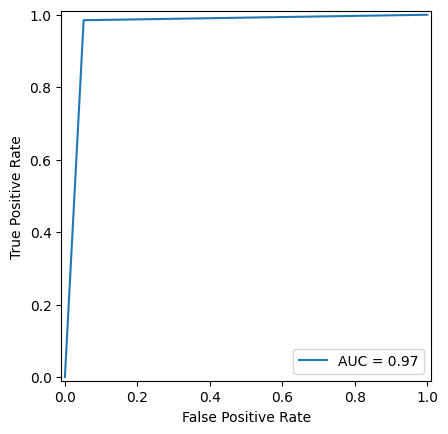

In [11]:
preds = clf.predict(val_data)
auc = roc_auc_score(val_labels, preds)
fpr, tpr, thresholds = roc_curve(val_labels, preds)
print(get_aupr(val_labels, preds, thresholds))
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auc)
disp.plot()

# SMOTE test

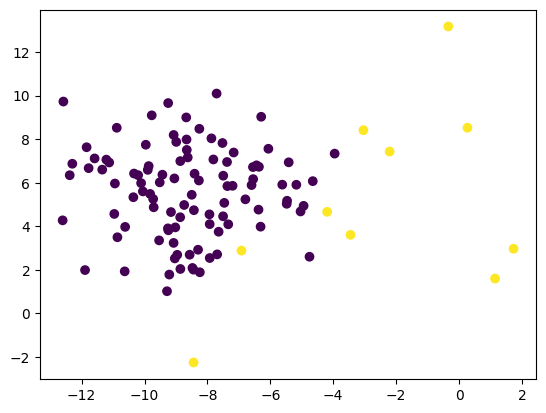

In [28]:
from sklearn.datasets import make_blobs
art_data, art_labels = make_blobs((100, 10), cluster_std = (2, 5), random_state = 7)
plt.scatter(art_data[:, 0], art_data[:, 1], c = art_labels)

In [29]:
sm = SMOTE()
sm.fit(art_data, art_labels)
new_art_data, new_art_labels = sm.resample()

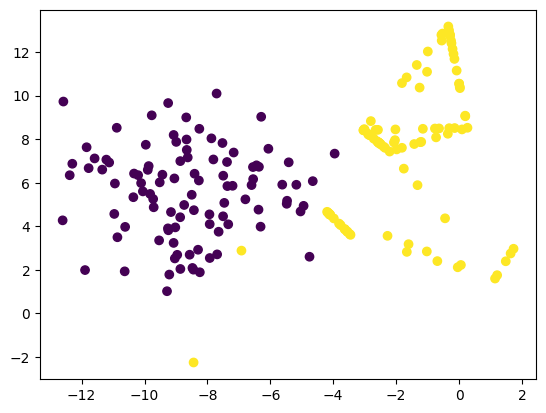

In [30]:
plt.scatter(new_art_data[:, 0], new_art_data[:, 1], c = new_art_labels)